# data building


In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# This block of code is to extract the details such as Day,Week,Month of the Date given which can be seen in the below block
df = pd.read_csv('data_daily.csv')
df['Date'] = pd.to_datetime(df['# Date'])
df.drop(columns=['# Date'], inplace=True)
df['Day'] = df['Date'].dt.day_name()
df['Week'] = df['Date'].dt.strftime('%W')
df['Month'] = df['Date'].dt.strftime('%m')

In [4]:
df.head()

,Receipt_Count,Date,Day,Week,Month
0,7564766,2021-01-01,Friday,00,01
1,7455524,2021-01-02,Saturday,00,01
2,7095414,2021-01-03,Sunday,00,01
3,7666163,2021-01-04,Monday,01,01
4,7771289,2021-01-05,Tuesday,01,01


In [5]:
#df_week is to have new list which has the average Receipt Count for each week (total 52 weeks)
df_week = df.groupby('Week')['Receipt_Count'].mean()
# df_day is to find the effect of Day of the week on the Receipt count.
# The values are calculated such that each value is a representaion of all sunday's count for a month
# and this is done to each month and all days.so total 7*12 entries
df_day = pd.DataFrame(columns=['index', 'Month', 'Day', 'meanRC'])
ind=0
for i in df['Month'].unique():
  for j in df['Day'].unique():
    a= df.loc[(df['Month'].values ==str(i)) & (df['Day'].values == str(j))]['Receipt_Count'].mean()
    new_row = pd.DataFrame({'index': [ind], 'Month': [i], 'Day': [j], 'meanRC': [a]})
    df_day = pd.concat([df_day, new_row], ignore_index=True)
    ind=ind+1;



In [6]:
df_day.head()
#in the below code shows for month 01(january) the average Receipts scanned on Friday is 7617672

,index,Month,Day,meanRC
0,0,01,Friday,7617672.6
1,1,01,Saturday,7649678.0
2,2,01,Sunday,7501845.0
3,3,01,Monday,7721032.0
4,4,01,Tuesday,7514209.5


In [7]:
# this command is to extrcat and trend and sesonal behavior in the week and day data
# we have observed both the Trends of week and day are linearly incresing,and the sesonal data is repeating 
# by this we can say the Data is repeating after few intervals.
# and the residual(noise after trend and seasonal is in range of 100000 
# which is 1%(low compared to the effect of trend and Season) of the total Receipt count)
decompose_week_month = seasonal_decompose(df_week, model='additive',period=4)
decompose_day_month = seasonal_decompose(df_day['meanRC'], model='additive',period=7)
decompose_daily_month = seasonal_decompose(df['Receipt_Count'], model='additive',period =30)

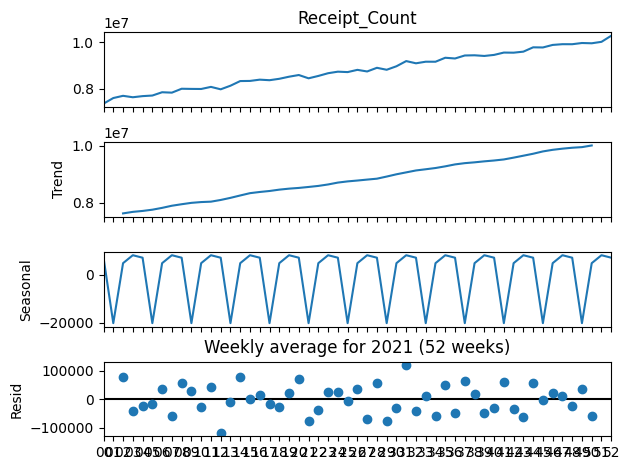

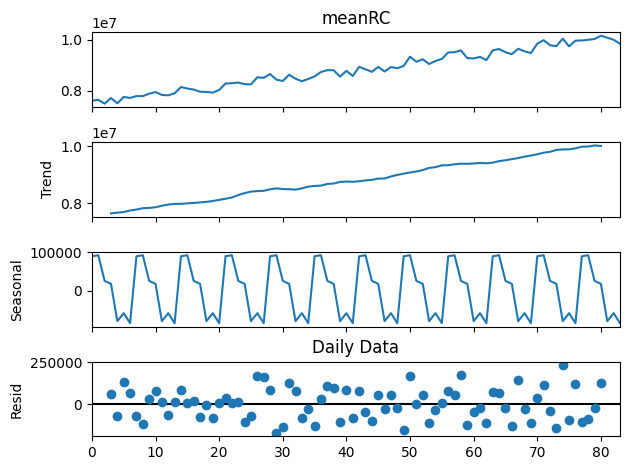

In [13]:
decompose_week_month.plot()
plt.title('Weekly average for 2021 (52 weeks)')
plt.show()
decompose_day_month.plot()
plt.title('Daily Data')
plt.show()

In [16]:
# This Blockof code is to extract the seasonal and Trend behavior of Day and Week data 
df_day_seasonal = decompose_day_month.seasonal
df_day_trend = decompose_day_month.trend
df_week_seasonal = decompose_week_month.seasonal
df_week_Trend = decompose_week_month.trend
df_week_Trend.dropna(inplace=True)
df_week_seasonal.dropna(inplace=True)

In [17]:
# This Block of code is to extract the pattern which is repeating for each 7 days
# This data will be added to the predicted trend to provide a offset 
day_shift = pd.DataFrame(columns=['index', 'weightage', 'Day'])
day_shift['index'] =np.arange(0,7)
day_shift['weightage'] = df_day_seasonal[:7]
day_shift['Day'] = df_day['Day'][:7]
week_shift = pd.DataFrame(df_week_seasonal[:4])
week_shift.reset_index(inplace=True)

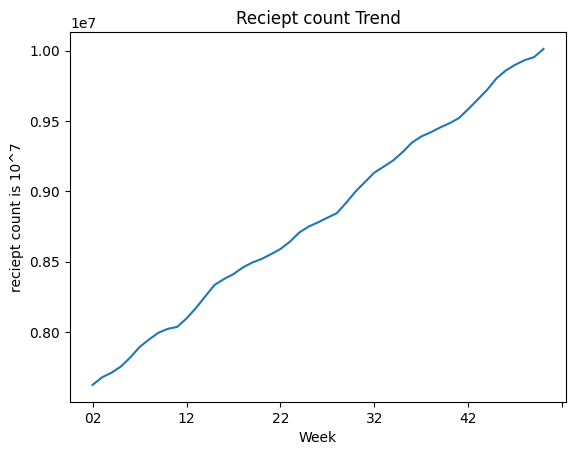

<Figure size 640x480 with 0 Axes>

In [14]:
# This Block of code is to extract the pattern which is repeating for each 4 weeks
# This data will be added to the predicted trend to provide a offset 
df_week_Trend.plot(x='Date',y='Receipt_Count',style='-')
plt.title('Receipt count Trend')
plt.ylabel('Receipt count is 10^7')
plt.show()
plt.savefig('Receipt_count_Trend_weekly_2021.png')

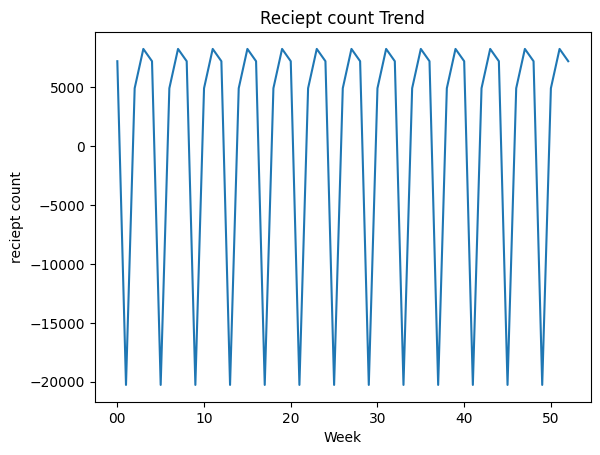

<Figure size 640x480 with 0 Axes>

In [ ]:
# detailed view of the repeating pattern obsered for each month 
df_week_seasonal.plot(x='Date',y='Receipt_Count',style='-')
plt.title('Receipt count Trend')
plt.ylabel('Receipt count')
plt.show()
plt.savefig('Receipt_count_seasonal_weekly_2021.png')

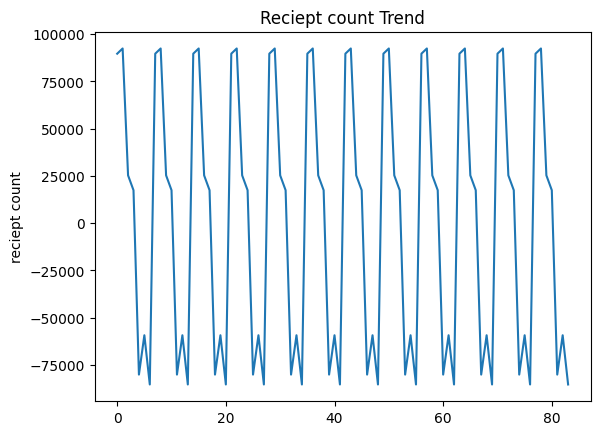

<Figure size 640x480 with 0 Axes>

In [15]:
# detailed view of the repeating pattern obsered for each day per month
df_day_seasonal.plot(x='Date',y='Receipt_Count',style='-')
plt.title('Receipt count Trend')
plt.ylabel('Receipt count')
plt.xlabel('')
plt.show()
plt.savefig('Receipt_count_seasonal_day_2021.png')

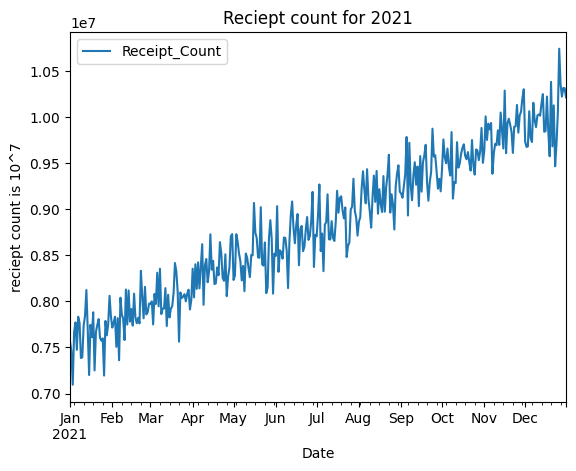

<Figure size 640x480 with 0 Axes>

In [14]:
# given Data
import seaborn as sns
import matplotlib.pyplot as plt
df.plot(x='Date',y='Receipt_Count',style='-')
plt.title('Receipt count for 2021')
plt.ylabel('Receipt count is 10^7')
plt.show()
plt.savefig('Receipt_count_2021.png')

# training the model for trend prediction

As we can observe the Trend plays and important componet in analyzing the growth and it is quite Linear.So I have used Linear Regression model to train the data on first 80% of the samples and test on the remaining 20%

In [18]:
df_train = df_week_Trend.iloc[:int(len(df_week_Trend)*0.80)]
df_test = df_week_Trend.iloc[int(len(df_week_Trend)*0.80):]

In [19]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(np.reshape(df_train.keys(),(-1,1)),df_train.values)


LinearRegression()

In [42]:
import pickle
pickle.dump(model, open('trend.pkl','wb'))

# testing (code to refer for predictions function in app.py)

In [20]:
import datetime
import calendar

def get_month_start_end(month_name, year=2022):
    if year is None:
        year = datetime.datetime.now().year

    # Converting month name to number
    month_number = datetime.datetime.strptime(month_name, '%B').month

    # Start date is always the 1st
    start_date = datetime.date(year, month_number, 1)

    # Find the last day of the month
    _, last_day = calendar.monthrange(year, month_number)
    end_date = datetime.date(year, month_number, last_day)

    return start_date, end_date

In [135]:
#Testing the predictions for the month of september
start_date, end_date = get_month_start_end("January")
start_date = pd.to_datetime(start_date)     # to convert start date into ppoper date format for evaluation
end_date = pd.to_datetime(end_date)         # to convert end date into prpoper date format for evaluation
start_week = start_date.strftime('%W')      # to get the week number of the start date (range from  00-(52~53))
end_week =end_date.strftime('%W')           # to get the week number of the end date (range from 00-(52~53))
givenmonth = start_date.strftime('%m')      # calculates month of the given start date

In [168]:
# this code is for plotting purpose 
yearstart = pd.to_datetime('2022-01-01')
plot_start_day=(start_date-yearstart).days
plot_end_day = (end_date-yearstart).days

In [77]:
# This Function will take the day(sunday,monday.....)of the date,week of the date, and month of the date to predict.
def get_trend_values(day,week,month):
  # The below line will give the average value predicted for that week .
  # lets say the input date is (2022-jan-15) the week is '02) so we have to provide an offset of 52 
  # and +2 is because the training is till Dec 20 (week 50) but there are 52 weeks in 2021
  pred_trend=model.predict(np.reshape(int(week)+2+52,(-1,1)));   
  # the below line provides and effect of offset cased due to the Day .(which we have observed in the seasonal pattern))
  day_sea = day_shift.loc[day_shift['Day'].values ==day]['weightage'].values;
   # the below line provides the effect of offset caused due to the week of the month .(which we have observed in the seasonal pattern))
  week_sea = week_shift.loc[week_shift['Week'].values == str('0'+str(int(week)%4))]['seasonal'].values;
  # The offsets can be is around 0 so we add the offset value to the trend 
  # By this we get the Range ,it can deviate due to the effect we have observed for the seasonal behavior of day and week
  # +-100000 is to adjust the residue from the decompose
  min_final = pred_trend+min(day_sea,week_sea) + 100000
  max_final = pred_trend+max(day_sea,week_sea) - 100000
  # final trend is the average of the min and max deviations to give equal importance to min and max values
  final_trend = (min_final+max_final)/2
  # max_range gives the % Range the values can deviate from its mean trend .
  max_range = abs(min_final-max_final)*100/pred_trend;
  return int(min_final),int(max_final),int(final_trend),float(max_range)



In [166]:
#all the return arrays are stored in outputs
outputs = []
#loop to evalute from startweek to end week number
for i in range(int(start_week),int(end_week)):
    for k in ('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday',"Saturday"):
      output = get_trend_values(k,str(i),givenmonth)
      outputs.append(output)
final_array = np.concatenate(outputs)

In [47]:
# this block of code is to extract the max trend,min trend,final trend and chnage% from the returned outputs
new_list = [inner_list[3] for inner_list in outputs]
low_list = [inner_list[0] for inner_list in outputs]
top_list = [inner_list[1] for inner_list in outputs]
trend_list = [inner_list[2] for inner_list in outputs]


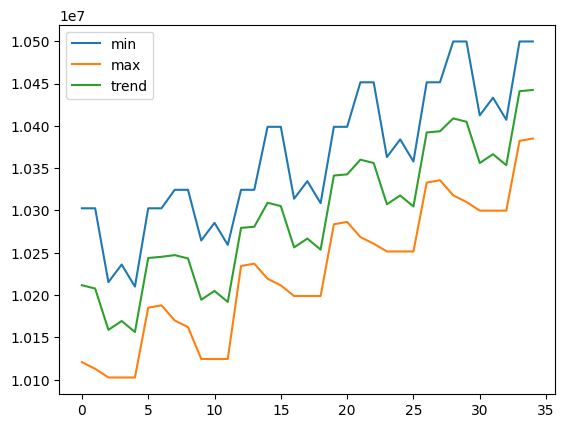

In [167]:
#To plot the graph
plt.plot( np.arange(plot_start_day,plot_start_day+len(outputs)), [row[0] for row in outputs], label='min')
plt.plot(np.arange(plot_start_day,plot_start_day+len(outputs)), [row[1] for row in outputs], label='max')
plt.plot(np.arange(plot_start_day,plot_start_day+len(outputs)), [row[2] for row in outputs], label='trend')
plt.legend()
plt.show()

In [23]:
resid_week = decompose_week_month.resid
resid_day = decompose_day_month.resid

In [171]:
resid_week.dropna().std()

50309.82863733077

we can observe the standard deveviation of the residual after the decompsotion and seasonal and trend,so to take this into account.we are adding max of both resid to the offset

In [170]:
resid_day.dropna().std()

93484.20139719162